In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry
from rdkit.Chem.rdMolTransforms import *

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules
from rmgpy.qm.main import QMCalculator, QMSettings
from rmgpy.qm.qmdata import QMData
from rmgpy.qm.reaction import QMReaction
from rmgpy.qm.molecule import QMMolecule






/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# This portion is for optimization of reactants and products 

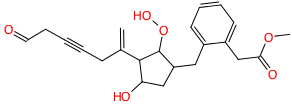

In [2]:
Molecule(SMILES="COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO")

In [3]:
def calc_energy(mol):
    """
    A function designed to calculate the energy of a molecule or TS
    
    Input: rdkit molecule object
    
    Output: energy of the geometry calculated using rdkit's forcefield method
    """
    molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    if molprop is None:
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        test_mol = Molecule(SMILES="COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO").toRDKitMol(removeHs=False)
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    return ff.CalcEnergy()

In [4]:
RDMol = Molecule(SMILES="CCOC")
RDMol

In [5]:
RDMol = RDMol.toRDKitMol(removeHs=False)

rdkit.Chem.AllChem.EmbedMolecule(RDMol)
#tsRDMol = rdkit.Chem.AddHs(tsRDMol)
print rdkit.Chem.MolToMolBlock(RDMol)
tsRDMol = rdkit.Chem.rdchem.RWMol(RDMol)

calc_energy(RDMol)



     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
    0.4165    0.3643   -0.2193 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7360   -0.2510    0.2369 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8461   -0.1072   -0.0207 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5743   -0.2728    0.4976 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.2878    0.3095   -1.3156 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.4174    1.4468    0.0462 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.1968    0.4349    0.9896 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.3957   -0.4679   -0.6149 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5786   -1.2058    0.7869 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0087    0.9522   -0.3434 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5497   -0.3815    0.8067 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0500   -0.8216   -0.8500 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  1  5  1  0
  1  4  1  0
  1  6  1  0
  2  7  1  0
  2  8  1  0
  2  9  1  0
  3 

11.825458626821561

## This portion creates rdkit molecules with hydrogens added

In [6]:

mol = Molecule(SMILES="CCOC")
mol

In [7]:
RDMol = mol.toRDKitMol(removeHs=False)
rdkit.Chem.AllChem.EmbedMolecule(RDMol)
print rdkit.Chem.MolToMolBlock(RDMol)
RDMol = rdkit.Chem.rdchem.RWMol(RDMol)

calc_energy(RDMol)


     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
   -0.3572   -0.2251   -0.5473 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6912   -0.0600    0.1719 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7734    0.2611    0.2518 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5048    0.7103   -0.0167 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5242    0.0085   -1.6297 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0327   -1.2676   -0.4328 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4266    0.4555   -0.4866 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5844    0.6039    1.0658 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0768   -1.0149    0.5526 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.5063    0.9856   -0.1858 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.9811   -0.7655   -0.1029 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.9274    0.3082    1.3597 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  1  4  1  0
  1  5  1  0
  1  6  1  0
  2  9  1  0
  2  7  1  0
  2  8  1  0
  3 

15.932090812133833

## This portion is what finds the torsions in a molecule. It should be able to handle rings as well

In [8]:

torsion_list = []

for bond1 in RDMol.GetBonds():
    
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are
        # not hydrogen or in a ring
        continue
    
    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue
        

    # Getting the 0th and 3rd atom and encuring that atoms 
    # attached to the 1st and 2nd atom are not all hydrogens
    # If not, we append a tuple of the torsion our torsion_list
    atom_count0 = 0
    hydrogen_count0 = 0
    
    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX
            atom_count0 += 1
        if atomX.GetAtomicNum() == 1:
            hydrogen_count0 += 1
            
    atom_count1 = 0
    hydrogen_count1 = 0
            
    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
            atom_count1 += 1
        if atomY.GetAtomicNum() == 1:
            hydrogen_count1 += 1
            
    if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)
    
torsion_list

[(5, 0, 3, 2)]

In [9]:
torsion_angles = np.arange(0, 360+10,10)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

df = []


torsion_combos
tup = RDMol.GetConformers()
conformer = tup[0]
for combo in torsion_combos:
    

    geometry = zip(torsion_list, combo)
    
    for torsion in geometry:
        i = torsion[0][0]
        j = torsion[0][1]
        k = torsion[0][2]
        l = torsion[0][3]
        angle = torsion[1]
        
        SetDihedralDeg(conformer,
                       i, 
                       j, 
                       k, 
                       l,
                       angle)
    
    df.append( [calc_energy(RDMol)] + list(combo))
    


In [10]:
df

[[16.560902635837213, 0],
 [16.301517312852205, 10],
 [15.681743933842109, 20],
 [14.884855874908949, 30],
 [14.130604260543826, 40],
 [13.614108063360385, 50],
 [13.473541491807193, 60],
 [13.775139520803187, 70],
 [14.501411622908144, 80],
 [15.536657393103312, 90],
 [16.65948870880982, 100],
 [17.5715308544716, 110],
 [17.99264063511241, 120],
 [17.800454320284494, 130],
 [17.116754561078796, 140],
 [16.27196635727251, 150],
 [15.709195644777683, 160],
 [15.935785834807655, 170],
 [17.56500281124431, 180],
 [21.493685297481946, 190],
 [29.491540016961135, 200],
 [46.65147597229367, 210],
 [91.7550957775909, 220],
 [216.1809243594638, 230],
 [383.4764378005046, 240],
 [300.9470824119604, 250],
 [131.8992355799008, 260],
 [58.847888399258814, 270],
 [33.41952347964997, 280],
 [22.938561096161138, 290],
 [18.031425292532507, 300],
 [15.83879279343254, 310],
 [15.172345069621844, 320],
 [15.359886244627948, 330],
 [15.900391977480174, 340],
 [16.39233820624376, 350],
 [16.56090263583714

In [11]:
i, j , k, l

(5, 0, 3, 2)

In [12]:
df = pd.DataFrame(df)
columns = ["Energy"]
for i in range(len(torsion_list)):
    columns.append("Tor " + str(i))

df.columns = columns

df.sort("Tor 0")

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Energy,Tor 0
0,16.560903,0
73,16.560903,0
72,16.301517,10
1,16.301517,10
2,15.681744,20
71,15.681744,20
3,14.884856,30
70,14.884856,30
69,14.130604,40
4,14.130604,40


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


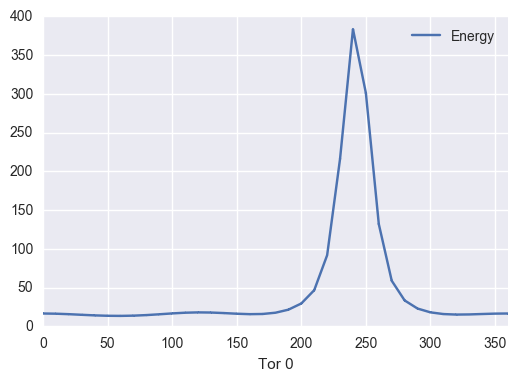

In [13]:
df.sort("Tor 0").plot("Tor 0")

# This next portion is designed to do the above but for a variety of molecules

In [14]:
list_of_smiles = [
    'CCCC',
    'CCCCC',
    'CCCCCC',
    'CCOC',
    "CCCC1(CCC)OCC(C)C1"
]

for smiles in list_of_smiles:
    mol = Molecule(SMILES=smiles)
    RDMol = mol.toRDKitMol(removeHs=False)

    rdkit.Chem.AllChem.EmbedMolecule(RDMol)
    #tsRDMol = rdkit.Chem.AddHs(tsRDMol)
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    torsion_list = []

    for bond1 in RDMol.GetBonds():

        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)
    print torsion_list
        
        
        

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    
    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        df.append( [calc_energy(RDMol), RDMol] + list(combo))
        

    df = pd.DataFrame(df)
    columns = ["Energy", "RDMol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns

    print df.sort("Energy").iloc[0]
    print df.sort("Energy").iloc[0]["RDMol"]
    print
    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    print


     RDKit          3D

 14 13  0  0  0  0  0  0  0  0999 V2000
    0.4669   -0.6315   -0.2341 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4429    0.4453    0.2775 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.8855   -0.0942   -0.0878 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.9050    0.1782   -0.0023 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.3129   -0.8972   -1.2891 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.3952   -1.4954    0.4616 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3315    0.4538    1.3910 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2240    1.4460   -0.1702 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.1467    0.5448   -0.9412 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.6193   -0.9313    0.0264 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.9112    0.4770    0.8741 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4499    1.0421    0.4602 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.2519   -0.7744    0.4606 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1325    0.2367   -1

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:109: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:110: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)



Energy                                            6.85633
RDMol     <rdkit.Chem.rdchem.RWMol object at 0x11253e998>
Tor 0                                                 180
Tor 1                                                 180
Tor 2                                                 300
Name: 375, dtype: object


     RDKit          3D

 20 19  0  0  0  0  0  0  0  0999 V2000
    0.6778    0.6034   -0.2695 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6746   -0.0507   -0.3696 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6639   -0.5366   -0.3171 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.6208   -1.5518   -0.3735 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5739   -0.5128   -1.5062 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3201   -1.9788   -1.6614 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.2768   -0.4871    0.6140 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.0683   -1.4641   -0.2415 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.7954    1.2586    0.6039 H   0  0  0  0  0  0  0  0 

## The following functions should be what you need to get the lowest energy conformer

In [15]:

def get_lowest_energy_conformer(smiles):
    mol = Molecule(SMILES=smiles)
    RDMol = mol.toRDKitMol(removeHs=False)

    rdkit.Chem.AllChem.EmbedMolecule(RDMol)
    
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    
    torsion_list = []
    for bond1 in RDMol.GetBonds():
        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        df.append( [calc_energy(RDMol), RDMol] + list(combo))
        
        
    df = pd.DataFrame(df)
    columns = ["Energy", "RDMol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns
    
    lowest_E_mol = df.sort("Energy").iloc[0]["RDMol"]
    print rdkit.Chem.MolToMolBlock(lowest_E_mol)

    lowest_E_mol = rdkit.Chem.AddHs(lowest_E_mol)
    rdkit.Chem.AllChem.UFFOptimizeMolecule(lowest_E_mol)
    
    #rdkit.Chem.AllChem.EmbedMolecule(lowest_E_mol)
    return lowest_E_mol
    
    

In [16]:
print rdkit.Chem.MolToMolBlock(get_lowest_energy_conformer("CCCC"))


     RDKit          3D

 14 13  0  0  0  0  0  0  0  0999 V2000
    0.3725    0.5530   -0.1317 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3736   -0.7198    0.2379 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.8597    0.4119   -0.0125 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7211   -1.7143    0.6103 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0099    1.3387    0.5579 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.1012    0.7561   -1.1980 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0371   -0.5602    1.1179 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9351   -1.1273   -0.6292 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.2715    1.4475    0.0799 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.2854   -0.0305   -0.9486 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.1957   -0.1680    0.8588 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1704   -2.0402   -0.3517 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5320   -1.1532    1.1422 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.3627   -2.5325    1

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:94: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# This next portion is designed to optimize the conformer for a Transition State

In [17]:
rxnFamily = ['H_Abstraction']
print('Loading RMG Database ...')
rmgDatabase = RMGDatabase()
databasePath = os.path.abspath(os.path.join(os.getenv('RMGpy', '..'), '..', 'RMG-database', 'input'))
print(databasePath)
rmgDatabase.load(databasePath,
                 kineticsFamilies=rxnFamily,
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'KlippensteinH2O2', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ],
                 solvation=False,
                 )
print('RMG Database Loaded')

#rxnFamily = reaction.family

tsDatabase = rmgDatabase.kinetics.families[rxnFamily[0]].transitionStates

settings = QMSettings(
    software='gaussian',
    method='m062x',
    fileStore=os.path.expandvars('.'),
    scratchDirectory=os.path.expandvars('.'),
    )

thermo.py:760 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from KlippensteinH2O2.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...


Loading RMG Database ...
/Users/nathan/Code/RMG-database/input


thermo.py:760 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:774 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:165 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/Code/RMG-database/input/statmech/groups...


RMG Database Loaded


In [18]:
rxn = Reaction(
    reactants=[Species(label="C2H6", molecule=[Molecule(SMILES="CC")]), 
               Species(label="HO2", molecule=[Molecule(SMILES="[O]O")])], 
    products=[Species(label="C2H5", molecule=[Molecule(SMILES="[CH2]C")]), 
              Species(label="H2O2", molecule=[Molecule(SMILES="OO")])])
rxn

In [19]:
rxn1 = QMReaction(
    reaction=rxn,
    settings=settings,
    tsDatabase=rmgDatabase)

In [20]:
reactant, product = rxn1.setupMolecules()
tsRDMol, tsBM, reactantGeom = rxn1.generateBoundsMatrix(reactant)
print rdkit.Chem.MolToMolBlock(tsRDMol)
tsRDMol = rdkit.Chem.rdchem.RWMol(tsRDMol)

reaction.py:300 generateBoundsMatrix INFO Generating bounds matrix for CC.[O]O



     RDKit          3D

 11  9  0  0  0  0  0  0  0  0999 V2000
    0.7545   -0.0040   -0.0370 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7538    0.0286   -0.0112 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1335   -0.8931   -0.5558 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.0575   -0.1244    1.0319 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1743    0.9475   -0.3811 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1565   -0.2047   -1.0281 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0706    1.0372    0.3287 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1389   -0.7870    0.6526 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.0149   -0.1631    0.0000 O   0  0  0  0  0  1  0  0  0  0  0  0
   -0.1494    0.4284   -0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8655   -0.2653   -0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  5  1  0
  1  2  1  0
  1  4  1  0
  1  3  1  0
  2  6  1  0
  2  8  1  0
  2  7  1  0
  9 10  1  0
 10 11  1  0
M  RAD  1   9   2
M  END

